In [2]:
# import all modules
import numpy as np
import PIL.Image as Image
import libtiff
from matplotlib import pyplot as plt
from skimage import io
from PRIS import SingleObs

# Construct obseration operator

In [3]:
# construct observation operator.
 # load psf matrix
dpath = './test_data/All_DH_NFz_NFx_NFy.tif';
im = io.imread(dpath)
psf = im[:,4*63:5*63,63*21:22*63]

# Load observation

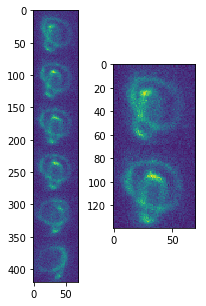

In [6]:
# load observation
data_path = './test_data';
f = 'Sample7_DH_FOV(00020).tif';
l = io.imread(data_path + '/' + f)
fov = l[:,665:735,1275:1345]
fov.shape
plt.figure(figsize=(5,5));
plt.subplot(131)
plt.imshow(fov[[1,3,5,6,10,15],:,:].reshape(6*fov.shape[1],fov.shape[2]))
blur1 = fov[1,:,:];
blur2 = fov[5,:,:];

blur = np.concatenate([blur1, blur2]).reshape(2*70,70);
plt.subplot(132)
plt.imshow(blur)

# Decide candidates

In [7]:
# decide candidates 
range_ind0 = np.arange(-30,25)
range_ind1 = np.arange(12,62,2)
range_ind2 = np.arange(10,60,2)
candidate_locs = list()
for i0 in range_ind0:
    for i1 in range_ind1:
        for i2 in range_ind2:
            candidate_locs.append([i0,i1,i2])

# Construct sensing matrix

In [8]:
# construct sensing matrix
    # dependencies: candidates, observation operator.
    # yield: sensing matrix
    # method: loop over all candidates and record the corresponding observations.
a = SingleObs()
a.psf = np.copy(psf)
a.psfz0 = 106
a.debug = False
a.imsize = blur1.shape
a.edge_padding = True
A = np.ndarray([blur.shape[0]*blur.shape[1], len(candidate_locs)+1])
A.shape
for count, loc in enumerate(candidate_locs):
#for count, loc in enumerate([[0,10,10],[10,10,10]]):
    
    loc1 = np.copy(loc); loc1[0] = np.copy(loc[0])-8
    loc2 = np.copy(loc); loc2[0] = np.copy(loc[0])+8
    a.location = loc1
    a.single_obs()
    a1 = a.obs.ravel()
    
    a.location = loc2
    a.single_obs()
    a2 = a.obs.ravel()
    
    A[:,count] = np.concatenate([a1.ravel(),a2.ravel()]).ravel()
A[:,len(candidate_locs)] = 1

# Recovery

In [9]:
# recover
    # input sensint matrix, and observation; 
    # yield: recovered vector
    # use scikit learn lasso solver
import time
from sklearn.linear_model import Lasso
print(A.shape)
print(blur.ravel().shape)
t = time.time()
rgr_lasso = Lasso(alpha = 50, max_iter = 5000, positive = True)
rgr_lasso.fit(A, blur.ravel())
rec_l1 = rgr_lasso.coef_[0 : len(candidate_locs)].reshape(len(range_ind0),len(range_ind1),len(range_ind2))
# do stuff
elapsed = time.time() - t
print(elapsed)


(9800, 34376)
(9800,)
563.6352729797363


# PRIS refinement \#1
   ## refine coordinates of candidates

226

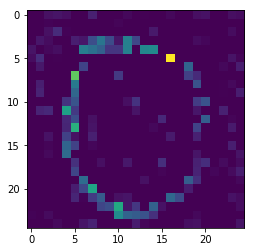

In [10]:
plt.imshow(np.mean(rec_l1,axis=0))
non_zero_inds = np.argwhere(rgr_lasso.coef_>0)
non_zero_coordinates = [candidate_locs[i] for i in list(non_zero_inds.ravel())]
non_zero_inds.size

In [11]:
non_zero_coordinates = [candidate_locs[i] for i in list(non_zero_inds.ravel())]

In [12]:
new_coords = list()
for i in non_zero_coordinates:    
    extra_coords=[[i[0] + 1, i[1], i[2]],\
                  [i[0] - 1, i[1], i[2]],\
                  [i[0], i[1] + 1, i[2]],\
                  [i[0], i[1] - 1, i[2]],\
                  [i[0], i[1], i[2] + 1],\
                  [i[0], i[1], i[2] - 1], i]
    for i1 in extra_coords:
        if i1 not in new_coords:
            new_coords.append(i1)



## calculate new sensing matrix

In [13]:
# construct sensing matrix
    # dependencies: candidates, observation operator.
    # yield: sensing matrix
    # method: loop over all candidates and record the corresponding observations.
a = SingleObs()
a.psf = np.copy(psf)
a.psfz0 = 106
a.debug = False
a.imsize = blur1.shape
a.edge_padding = True
A = np.ndarray([blur.shape[0]*blur.shape[1], len(new_coords)+1])
A.shape
for count, loc in enumerate(new_coords):
#for count, loc in enumerate([[0,10,10],[10,10,10]]):
    
    loc1 = np.copy(loc); loc1[0] = np.copy(loc[0])-8
    loc2 = np.copy(loc); loc2[0] = np.copy(loc[0])+8
    a.location = loc1
    a.single_obs()
    a1 = a.obs.ravel()
    
    a.location = loc2
    a.single_obs()
    a2 = a.obs.ravel()
    
    A[:,count] = np.concatenate([a1.ravel(),a2.ravel()]).ravel()
A[:,len(new_coords)] = 1000000

## new recovery

In [14]:
# recover
    # input sensint matrix, and observation; 
    # yield: recovered vector
    # use scikit learn lasso solver

import time
from sklearn.linear_model import Lasso
print(A.shape)
print(blur.ravel().shape)
t = time.time()
rgr_lasso = Lasso(alpha=1,max_iter=5000,positive=True)
rgr_lasso.fit(A, blur.ravel())
elapsed = time.time() - t
print(elapsed)

(9800, 1503)
(9800,)
57.62585115432739


## visualize the recovered result

0.0


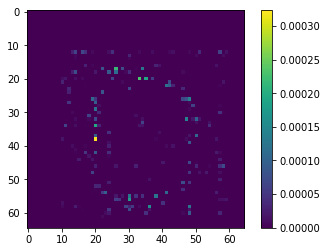

In [15]:
rec_l1 = rgr_lasso.coef_[0:len(new_coords)]
# do stuff
rec = np.zeros((60,65,65))
for ind, loc in enumerate(new_coords):
    rec[loc[0]+30,loc[1],loc[2]] = rec_l1[ind-1]
    
plt.imshow(np.mean(rec,axis=0))
plt.colorbar()
print(rgr_lasso.coef_[len(new_coords)])

# PRIS refinement #2

## refine coordinates of candidates

In [16]:
l = float()